**Project 2 - Advanced Corporate Finance**

Humphrey Hui - hh32346

Peyton Gibbs - peg694

Jack Feen - jaf5542

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
from typing import List
import seaborn as sns
from sklearn.covariance import LedoitWolf
import cvxpy as cp

# Data Collection

In [4]:
import wrds
db = wrds.Connection()

Loading library list...
Done


In [5]:
def data_and_constraints_acquisition(max_missing_pct = 0.1):
    tickers = []
    while True:
        ticker = input("Please input a ticker. If you're finished, enter 'done': ")
        if ticker.lower() == "done":
            if not tickers:
                print("No tickers entered. Please enter at least one.")
                continue
            break
        else:
            tickers.append(ticker.upper())
            
    while True:
        tickers_sql = ",".join([f"'{t}'" for t in tickers])
        crsp = db.raw_sql(
            f"""
            SELECT
                B.TICKER,
                A.DATE,
                A.RET
            FROM CRSP.MSF AS A
            LEFT JOIN CRSP.MSENAMES AS B
                ON A.PERMNO = B.PERMNO
                AND B.NAMEDT <= A.DATE
                AND A.DATE <= B.NAMEENDT
            WHERE B.TICKER IN ({tickers_sql})
              AND A.DATE BETWEEN '2010-01-01' AND '2024-12-31'
              AND B.EXCHCD BETWEEN 1 AND 3
              AND B.SHRCD IN (10, 11)
            ORDER BY B.TICKER, A.DATE;
            """
        )
        # convert date to datetime
        crsp['date'] = pd.to_datetime(crsp['date'])
        
        # align CRSP dates to calendar month-end (Necessary for creating a uniform, complete index)
        crsp['date'] = crsp['date'] + pd.offsets.MonthEnd(0)
        
        # pivot to wide format
        crsp_wide = crsp.pivot(index = "date", columns = "ticker", values = "ret")
        
        # create the full expected time series for checks
        start_date = '2010-01-31'
        end_date = '2024-12-31'
        full_calendar_index = pd.date_range(start = start_date, end = end_date, freq = 'ME')

        # reindex using the full calendar index to introduce NaNs for missing months
        crsp_wide = crsp_wide.reindex(full_calendar_index)
        crsp_wide.index.name = "date"

        # check for bad tickers
        bad_ticker = None
        for t in crsp_wide.columns:
            series = crsp_wide[t]
            # check consecutive NAs
            is_na = series.isna()
            groups = (~is_na).cumsum()
            na_run_lengths = is_na.groupby(groups).sum()
            # check total % missing
            pct_missing = is_na.mean()
            
            if (na_run_lengths >= 3).any() or (pct_missing > max_missing_pct):
                bad_ticker = t
                print(f"Ticker {bad_ticker} failed coverage check: ")
                if (na_run_lengths >= 3).any():
                    print("3+ consecutive missing months")
                if pct_missing > max_missing_pct:
                    print(f"{pct_missing:.1%} total missing (> {max_missing_pct:.0%} allowed)")
                na_months = series[series.isna()].index.strftime('%Y-%m')
                print(f"Missing months: {list(na_months)}")
                break
            # fill gaps with 0 return
            crsp_wide[t] = series.fillna(0)
            
        if bad_ticker:
            new_ticker = input(f"Please input a replacement for {bad_ticker}: ").upper()
            tickers = [new_ticker if x == bad_ticker else x for x in tickers]
            continue
        else:
            print("Final dataset acquired: all tickers meet coverage rules.")
            break
        
    optimization_constraints = {}
    for ticker in tickers:
        print(f"\nConstraints for {ticker}:")
        print("1. Both min and max constraints")
        print("2. Only minimum constraint")
        print("3. Only maximum constraint")
        print("4. No constraints")
        
        while True:
            choice = input("Choose option (1-4): ")
            try:
                if choice == "1":
                    ticker_min = float(input(f"Minimum weight for {ticker}: "))
                    ticker_max = float(input(f"Maximum weight for {ticker}: "))
                    optimization_constraints[ticker] = [ticker_min, ticker_max]
                    break
                elif choice == "2":
                    ticker_min = float(input(f"Minimum weight for {ticker}: "))
                    optimization_constraints[ticker] = [ticker_min, None]
                    break
                elif choice == "3":
                    ticker_max = float(input(f"Maximum weight for {ticker}: "))
                    optimization_constraints[ticker] = [None, ticker_max]
                    break
                elif choice == "4":
                    optimization_constraints[ticker] = [None, None]
                    break
                else:
                    print("Invalid choice. Please enter 1, 2, 3, or 4.")
            except ValueError:
                print("Invalid input. Please enter a valid number for the weight.")
                
    return crsp_wide, optimization_constraints

df, optimization_constraints = data_and_constraints_acquisition(max_missing_pct = 0.1)
print(df)
print(optimization_constraints)

Please input a ticker. If you're finished, enter 'done':  amd
Please input a ticker. If you're finished, enter 'done':  aapl
Please input a ticker. If you're finished, enter 'done':  amzn
Please input a ticker. If you're finished, enter 'done':  msft
Please input a ticker. If you're finished, enter 'done':  nvda
Please input a ticker. If you're finished, enter 'done':  lii
Please input a ticker. If you're finished, enter 'done':  googl
Please input a ticker. If you're finished, enter 'done':  done


Ticker GOOGL failed coverage check: 
3+ consecutive missing months
28.3% total missing (> 10% allowed)
Missing months: ['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03']


Please input a replacement for GOOGL:  goog


Final dataset acquired: all tickers meet coverage rules.

Constraints for AMD:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4



Constraints for AAPL:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4



Constraints for AMZN:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4



Constraints for MSFT:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4



Constraints for NVDA:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4



Constraints for LII:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4



Constraints for GOOG:
1. Both min and max constraints
2. Only minimum constraint
3. Only maximum constraint
4. No constraints


Choose option (1-4):  4


ticker          AAPL       AMD      AMZN      GOOG       LII      MSFT  \
date                                                                     
2010-01-31 -0.088591 -0.229339 -0.067722 -0.145224 -0.021004 -0.075459   
2010-02-28   0.06538  0.060322 -0.055897 -0.005933  0.104134  0.022001   
2010-03-31   0.14847  0.171934  0.146706  0.076538  0.053791  0.021538   
2010-04-30  0.111021 -0.021575  0.009796 -0.073045  0.021209  0.042595   
2010-05-31 -0.016125 -0.055127 -0.084902 -0.076213 -0.011268 -0.150811   
...              ...       ...       ...       ...       ...       ...   
2024-08-31  0.032286  0.028239 -0.045352 -0.046434  0.011465   -0.0011   
2024-09-30  0.017467   0.10447  0.043866  0.013809  0.025839  0.031548   
2024-10-31 -0.030429 -0.121953  0.000376  0.032897 -0.002846 -0.055659   
2024-11-30  0.051658 -0.047859   0.11529  -0.01274  0.107141  0.044149   
2024-12-31  0.055155 -0.119446  0.055318  0.118189 -0.084961 -0.004629   

ticker          NVDA  
date          

In [6]:
df = df.drop(df.index[0])
df = df.drop(df.index[1])
df

ticker,AAPL,AMD,AMZN,GOOG,LII,MSFT,NVDA
date,,,,,,,
2010-02-28,0.06538,0.060322,-0.055897,-0.005933,0.104134,0.022001,0.052632
2010-04-30,0.111021,-0.021575,0.009796,-0.073045,0.021209,0.042595,-0.097126
2010-05-31,-0.016125,-0.055127,-0.084902,-0.076213,-0.011268,-0.150811,-0.16359
2010-06-30,-0.020827,-0.145858,-0.129125,-0.083768,-0.06771,-0.10814,-0.222983
2010-07-31,0.022741,0.023224,0.078986,0.089673,0.050517,0.121686,-0.099902
...,...,...,...,...,...,...,...
2024-08-31,0.032286,0.028239,-0.045352,-0.046434,0.011465,-0.0011,0.020082
2024-09-30,0.017467,0.10447,0.043866,0.013809,0.025839,0.031548,0.017425
2024-10-31,-0.030429,-0.121953,0.000376,0.032897,-0.002846,-0.055659,0.093215


# GMV Optimization

In [8]:
# We were getting floating point symmetry errors, chatGPT made this to fix them

import numpy as np

def make_symmetric(mat):
    """
    Force a square matrix to be symmetric.
    Optionally, clip tiny negative eigenvalues to ensure PSD.
    """
    # Average with its transpose
    sym = (mat + mat.T) / 2
    
    # Optional: force positive semi-definite
    eigvals, eigvecs = np.linalg.eigh(sym)
    eigvals[eigvals < 0] = 0
    sym_psd = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    return sym_psd


In [9]:
def gmv_optimized(rawret, opt_constraints):

    avg_rawret_per = rawret.mean()
    variance_per = rawret.var()
    avg_variance = variance_per.mean()
    demeaned = rawret - avg_rawret_per
    T = len(rawret)
    tickers = rawret.columns.to_list()
    n = len(tickers)

    # Sample covariance matrix
    covmat_array = np.dot(demeaned.T, demeaned) / (T - 1)
    covmat = pd.DataFrame(covmat_array, columns=tickers, index=tickers)


    # Convert to NumPy array for cvxpy
    covmat_np = covmat.apply(pd.to_numeric).to_numpy()
    covmat_np = make_symmetric(covmat_np)  # ensure symmetry & PSD

    
    # Constraints
    lower_bound = pd.Series({t: opt_constraints[t][0] for t in tickers})
    upper_bound = pd.Series({t: opt_constraints[t][1] for t in tickers})
    lower = lower_bound.reindex(tickers).to_numpy(dtype=float)
    upper = upper_bound.reindex(tickers).to_numpy(dtype=float)

    # Optimization variable
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1]

    mask_lo = np.isfinite(lower)
    if mask_lo.any():
        constraints.append(w[mask_lo] >= lower[mask_lo])
    mask_up = np.isfinite(upper)
    if mask_up.any():
        constraints.append(w[mask_up] <= upper[mask_up])

    # Objective: minimize portfolio variance using sample covariance
    obj = cp.Minimize(cp.quad_form(w, covmat_np))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.OSQP)

    # Return weights
    w_opt = w.value
    weights = pd.Series(w_opt, index=tickers)
    return weights

# Example usage
weights_sample = gmv_optimized(df, optimization_constraints)
print(weights_sample)


AAPL    0.152433
AMD    -0.056233
AMZN    0.023293
GOOG    0.191824
LII     0.350829
MSFT    0.420181
NVDA   -0.082326
dtype: float64


In [10]:
def lw_gmv_optimized(rawret,opt_constraints):
    
    avg_rawret_per = rawret.mean()
    variance_per = rawret.var()
    avg_variance = variance_per.mean()
    demeaned = rawret - avg_rawret_per
    T = len(rawret)
    tickers = rawret.columns.to_list()
    n = len(tickers)
    
    covmat_array = np.dot(demeaned.T,demeaned)/(T-1)
    covmat = pd.DataFrame(covmat_array, columns = tickers, index = tickers)
    lw = LedoitWolf(assume_centered=True).fit(demeaned)
    lwcovmat_array = lw.covariance_
    lwcovmat = pd.DataFrame(lwcovmat_array, columns = tickers, index = tickers)
    lwcovmat_np = lwcovmat.apply(pd.to_numeric).to_numpy()
    lwcovmat_np = make_symmetric(lwcovmat_np)  # ensure symmetry & PSD

    
    lower_bound = pd.Series({t: opt_constraints[t][0] for t in tickers}) 
    upper_bound = pd.Series({t: opt_constraints[t][1] for t in tickers}) 
    upper = upper_bound.reindex(tickers).to_numpy(dtype=float)
    lower = lower_bound.reindex(tickers).to_numpy(dtype=float)
    
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1]
    mask_lo = np.isfinite(lower)
    mask_lo
    if mask_lo.any():
        constraints.append(w[mask_lo] >= lower[mask_lo])
    mask_up = np.isfinite(upper)
    if mask_up.any():
        constraints.append(w[mask_up] <= upper[mask_up])
        
    obj = cp.Minimize(cp.quad_form(w, lwcovmat_np))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.OSQP)
    
    w_opt = w.value
    weights = pd.Series(w_opt, index=tickers)
    return weights

lw_gmv_optimized(df,optimization_constraints)

AAPL    0.160978
AMD    -0.052974
AMZN    0.039478
GOOG    0.199826
LII     0.340334
MSFT    0.385867
NVDA   -0.073510
dtype: float64

# Out of Sample Backtesting

In [41]:
# Number of months for backtesting
roll = int(input("Enter your desired backtesting period (e.g. 36 for 36 months): "))
# Compute start date
start = df.index.min() + pd.DateOffset(months=roll)

# Store results for plotting
results = {}
# Store weights
result_weights = {}

def get_lookback_rets(roll, start_date=start):

    # Lists to store out-of-sample returns
    roll_rets = []
    lw_roll_rets = []

    # Lists to store weights for each OOS month
    roll_weights_list = []
    lw_roll_weights_list = []

    for lookback_end in df.index[df.index >= start_date]:
        lookback_start = lookback_end - pd.DateOffset(months=roll)
        lookback_rets = df.loc[(df.index > lookback_start) & (df.index <= lookback_end)]

        # Skip if lookback window is empty
        if lookback_rets.empty:
            continue

        # Compute GMV weights
        w_gmv = gmv_optimized(lookback_rets, optimization_constraints)
        # Compute LW-GMV weights
        w_lw = lw_gmv_optimized(lookback_rets, optimization_constraints)

        # Compute out-of-sample return for the next month
        next_idx = df.index.get_loc(lookback_end) + 1
        if next_idx < len(df):
            oos_month = df.iloc[next_idx]

            # Out-of-sample returns
            roll_rets.append((df.index[next_idx], (oos_month * w_gmv).sum()))
            lw_roll_rets.append((df.index[next_idx], (oos_month * w_lw).sum()))

            # Store corresponding weights
            roll_weights_list.append(w_gmv)
            lw_roll_weights_list.append(w_lw)

    # Convert returns to DataFrames
    roll_rets_df = pd.DataFrame(roll_rets, columns=['date','return']).set_index('date')
    lw_roll_rets_df = pd.DataFrame(lw_roll_rets, columns=['date','return']).set_index('date')

    # Compute monthly log returns
    log_sample = np.log1p(roll_rets_df['return'])
    log_lw = np.log1p(lw_roll_rets_df['return'])

    # Store results
    results[roll] = (log_sample, log_lw)

    # Store weights as DataFrames (rows = OOS months, columns = tickers)
    result_weights[roll] = {
        'gmv': pd.DataFrame(roll_weights_list, index=roll_rets_df.index),
        'lw_gmv': pd.DataFrame(lw_roll_weights_list, index=lw_roll_rets_df.index)
    }


Enter your desired backtesting period (e.g. 36 for 36 months):  36


In [45]:
# Different Rollback periods to test on
rollback_months = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]

# Run get_lookback_rets for each rollback period
for i in rollback_months:
    get_lookback_rets(i, start_date = df.index.min() + pd.DateOffset(months = i))

# Portfolio Returns Analysis

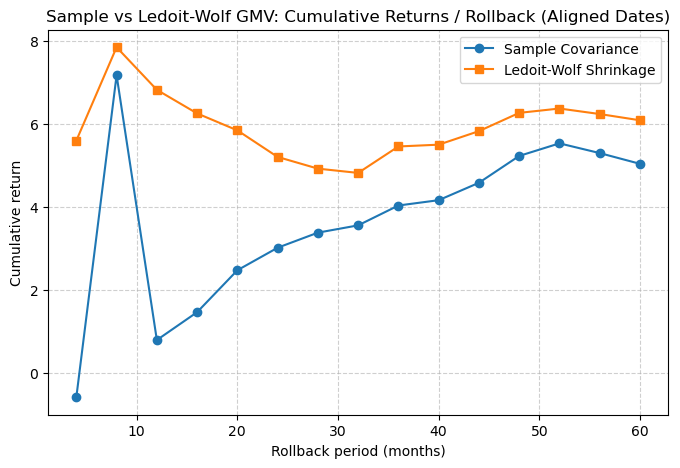

In [46]:
# Plot cum rets / rollback period

# find smallest length
min_len = min(min(len(results[p][0]), len(results[p][1])) for p in results)

# truncate each series to the *last* min_len elements
periods = sorted(results.keys())

# Compute cumulative simple returns from log returns
sample_cum = [np.expm1(results[p][0].iloc[-min_len:].sum()) for p in periods]
lw_cum     = [np.expm1(results[p][1].iloc[-min_len:].sum()) for p in periods]

# plot
plt.figure(figsize=(8,5))
plt.plot(periods, sample_cum, marker='o', label="Sample Covariance")
plt.plot(periods, lw_cum, marker='s', label="Ledoit-Wolf Shrinkage")
plt.xlabel("Rollback period (months)")
plt.ylabel("Cumulative return")
plt.title("Sample vs Ledoit-Wolf GMV: Cumulative Returns / Rollback (Aligned Dates)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Because a 4 month and 4 year rolling average would be computed on different portions of the data, we calculated cumulative return on the maximum last N months of the dataset that ensures that all returns are calculated on the same period. The Ledoit Wolf - designed to shink noise has less variance across its average monthly  returns on out of sample data. The effects of shinking covariance due to noise can be seen by the better out of sample performance of the LW model.

To see if Ledoit Wolf is effective at minimizing variance in smaller lookback periods, we used our out of sample data once again to plot portfolio variance against the rollback period for Sample and LW.

In [17]:
# Annualized return for lw and sample

def annualized_return(roll):

    if roll not in results:
        raise ValueError(f"Rollback period {roll} not found in results.")

    log_sample = results[roll][0]
    log_lw     = results[roll][1]

    # Compute mean monthly log return
    mean_log_sample = log_sample.mean()
    mean_log_lw     = log_lw.mean()

    # Annualize
    annual_log_sample = mean_log_sample * 12
    annual_log_lw     = mean_log_lw * 12

    # Convert to simple annual return
    ann_sample = np.expm1(annual_log_sample)
    ann_lw     = np.expm1(annual_log_lw)

    # Convert to percent
    ann_sample = ann_sample * 100
    ann_lw = ann_lw * 100
    
    print('Sample Annualized Return:', ann_sample, '%')
    print("Ledoit Wolf Annualized Reutrn:", ann_lw, '%')


In [18]:
print('Rollback = 8 months')
annualized_return(8)
print('Rollback = 32 months')
annualized_return(32)

Rollback = 8 months
Sample Annualized Return: 32.029840275130574 %
Ledoit Wolf Annualized Reutrn: 24.284187444111545 %
Rollback = 32 months
Sample Annualized Return: 17.47046249135037 %
Ledoit Wolf Annualized Reutrn: 20.796610779567157 %


### Portfolio Variance Analysis

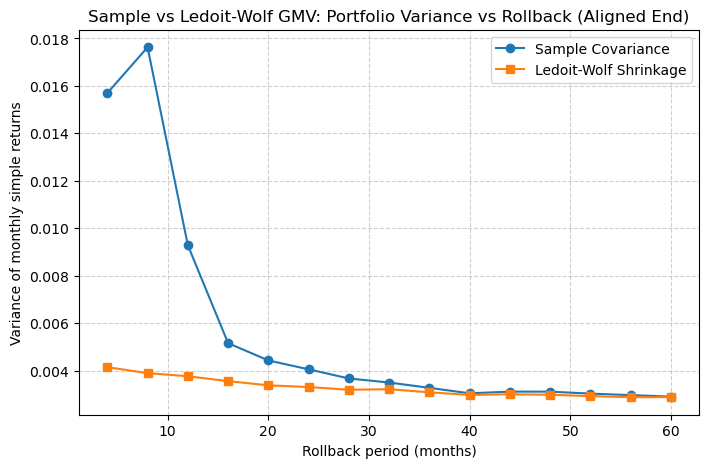

In [20]:
# calculate variance of simple returns
sample_var_simple = [np.var(np.expm1(results[p][0].iloc[-min_len:]), ddof=1) for p in periods]
lw_var_simple     = [np.var(np.expm1(results[p][1].iloc[-min_len:]), ddof=1) for p in periods]

# plot
plt.figure(figsize=(8,5))
plt.plot(periods, sample_var_simple, marker='o', label="Sample Covariance")
plt.plot(periods, lw_var_simple, marker='s', label="Ledoit-Wolf Shrinkage")
plt.xlabel("Rollback period (months)")
plt.ylabel("Variance of monthly simple returns")
plt.title("Sample vs Ledoit-Wolf GMV: Portfolio Variance vs Rollback (Aligned End)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


As expected, the sample covariance method starts off with extreme variance that converages to the Ledoit Wolf variance as we increase the number of rollback periods. Portfolio variance continues to descrease as far as 60 months out for a rollback period.

In [22]:
# Sharpe ratio
def portfolio_sharpe(roll, risk_free_rate=0.04/12):

    log_sample, log_lw = results[roll]
    
    # Convert to simple monthly returns
    ret_sample = np.expm1(log_sample)
    ret_lw = np.expm1(log_lw)
    
    # Excess returns
    excess_sample = ret_sample - risk_free_rate
    excess_lw = ret_lw - risk_free_rate
    
    # Annualized Sharpe
    sharpe_sample = (np.mean(excess_sample) / np.std(excess_sample)) * np.sqrt(12)
    sharpe_lw = (np.mean(excess_lw) / np.std(excess_lw)) * np.sqrt(12)
    
    return {"sample": sharpe_sample, "lw": sharpe_lw}

portfolio_sharpe(32)



{'sample': 0.7265391359035359, 'lw': 0.9093845548302455}

The Ledoit Wolf is able to get a better out of sample Sharpe ratio.

# Weights Analysis

In [49]:
def plot_portfolio_weights(roll):
    if roll not in result_weights:
        raise ValueError(f"Rollback period {roll} not found in result_weights.")

    gmv_weights = result_weights[roll]['gmv'] * 100  # convert to %
    lw_weights = result_weights[roll]['lw_gmv'] * 100  # convert to %

    # Determine common y-axis limits across both portfolios
    min_weight = min(gmv_weights.min().min(), lw_weights.min().min())
    max_weight = max(gmv_weights.max().max(), lw_weights.max().max())

    # --- GMV weights ---
    plt.figure(figsize=(12,6))
    for col in gmv_weights.columns:
        plt.plot(gmv_weights.index, gmv_weights[col], label=col)
    plt.title(f"GMV Portfolio Weights Over Time (Rollback {roll} months)")
    plt.xlabel("Date")
    plt.ylabel("Weight (%)")
    plt.ylim(min_weight - 5, max_weight + 5)  # add small padding
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

    # --- LW-GMV weights ---
    plt.figure(figsize=(12,6))
    for col in lw_weights.columns:
        plt.plot(lw_weights.index, lw_weights[col], label=col)
    plt.title(f"LW-GMV Portfolio Weights Over Time (Rollback {roll} months)")
    plt.xlabel("Date")
    plt.ylabel("Weight (%)")
    plt.ylim(min_weight - 5, max_weight + 5)  # same y-axis as GMV
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

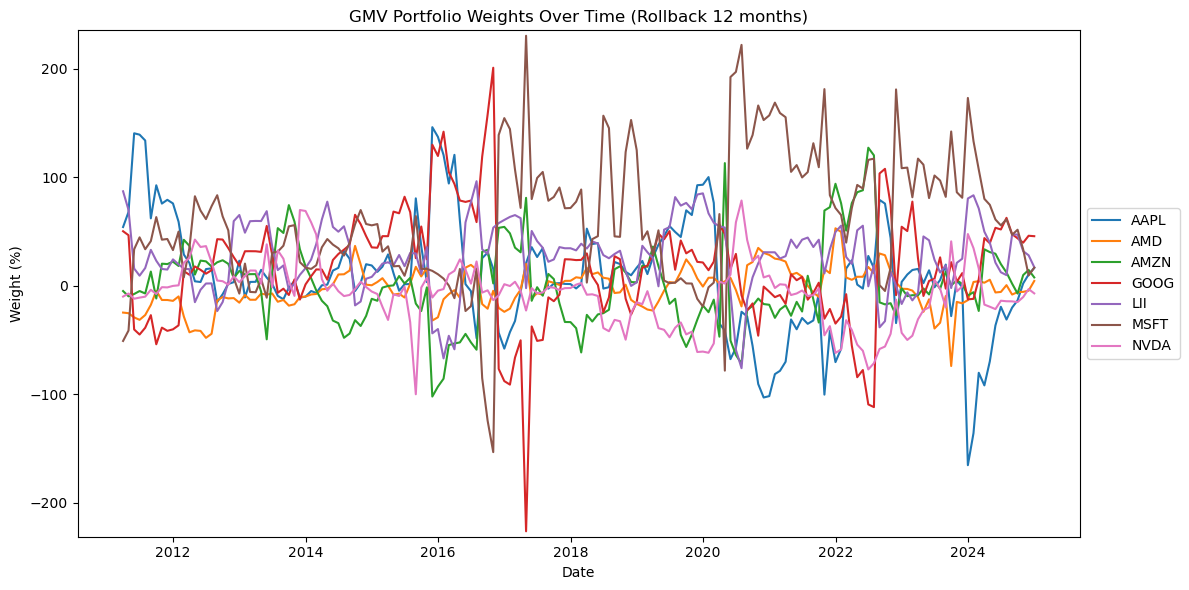

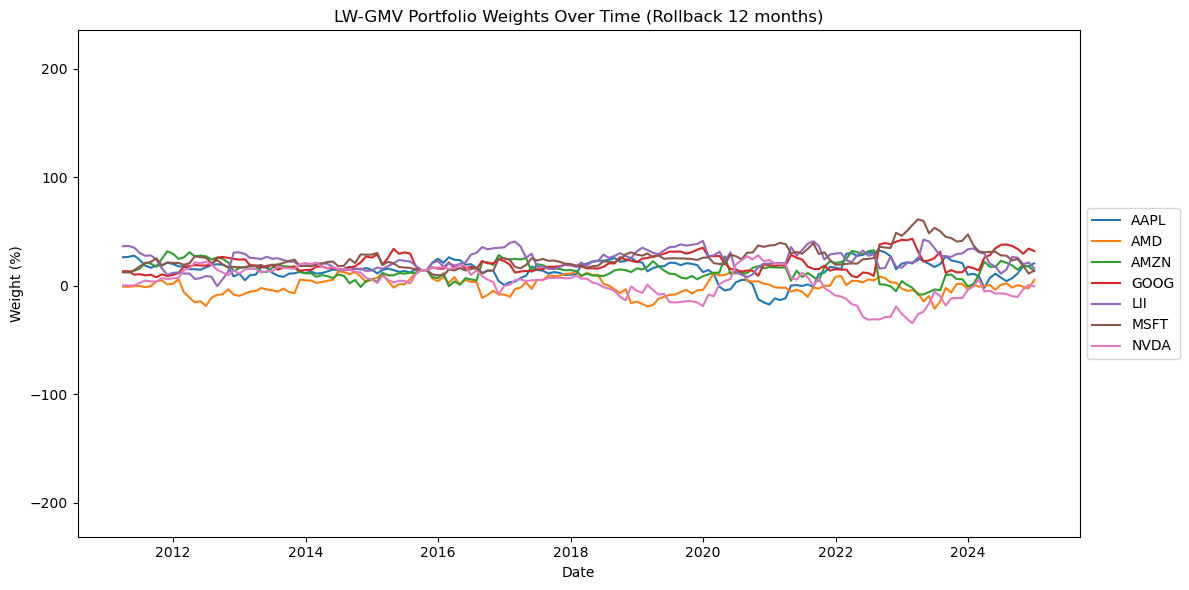

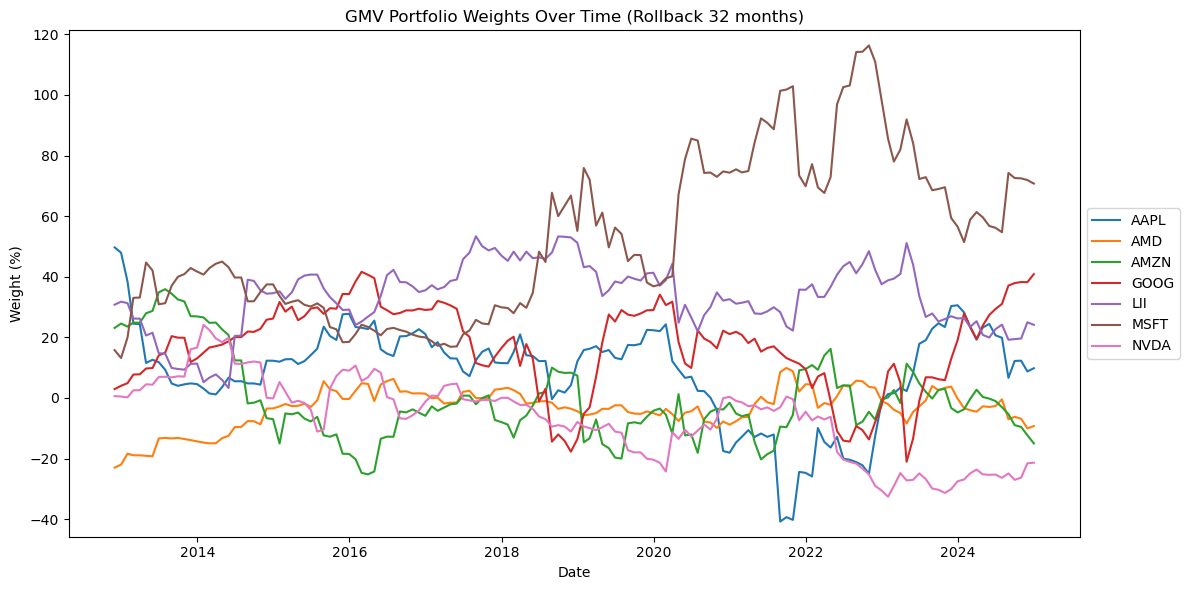

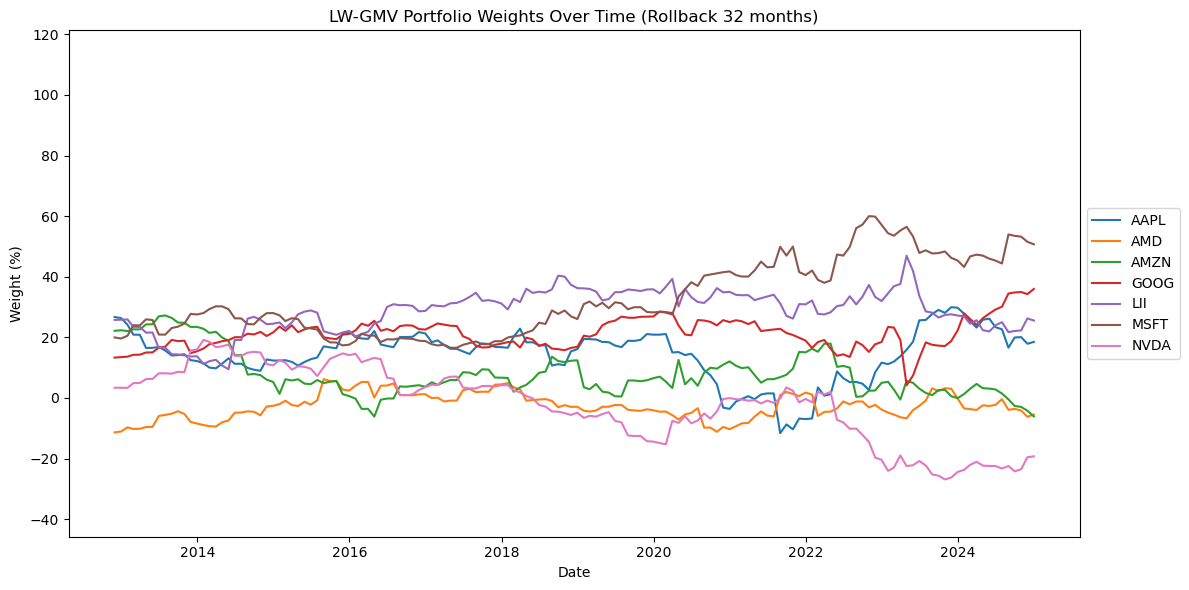

In [53]:
plot_portfolio_weights(12)
plot_portfolio_weights(32)

As expected, the Ledoit Wolf produce even, stable weights compared to the sample covariance. Additionally, the weights become more stable as the rollback period increases, as stock covariances can be calculated with less noise.

While visually obvious, lets verify these results by creating a function that uses the last day to calculate the standard devaition of porfolio weights...

In [28]:
def weight_std(roll):

    if roll not in result_weights:
        raise ValueError(f"Rollback period {roll} not found in result_weights.")

    gmv_weights = result_weights[roll]['gmv']
    lw_weights = result_weights[roll]['lw_gmv']

    # Take the last row (last day)
    last_gmv = gmv_weights.iloc[-1]
    last_lw = lw_weights.iloc[-1]

    # Standard deviation across tickers
    std_gmv = last_gmv.std()
    std_lw = last_lw.std()

    print("Sample covariance standard devation of weights (Last Day):", std_gmv)
    print("Ledoit Wolf standard devation of weights (Last Day):", std_lw)


In [29]:
print('Rollback period = 4')
weight_std(4)

print('Rollback period = 32')
weight_std(32)

Rollback period = 4
Sample covariance standard devation of weights (Last Day): 0.1333740134620739
Ledoit Wolf standard devation of weights (Last Day): 0.08995728409018695
Rollback period = 32
Sample covariance standard devation of weights (Last Day): 0.3408845206982877
Ledoit Wolf standard devation of weights (Last Day): 0.25154535767491


... and as expected, the Ledoit Wolf maintains a lower standard deviation of weights.

In [35]:
# Compute weight turnover for a given rollback period
def compute_weight_turnover(roll):

    weights_dict = result_weights.get(roll)
    if weights_dict is None:
        raise ValueError(f"No weights found for roll={roll}")
    
    turnover = {}
    for key in ['gmv', 'lw_gmv']:
        df_weights = weights_dict[key]
        # Compute absolute change month-over-month
        turnover[key] = df_weights.diff().abs().sum(axis=1)
        turnover[key].iloc[0] = 0  # first month has no previous weights
    
    return turnover

turnover_32 = compute_weight_turnover(32)
turnover_12 = compute_weight_turnover(12)

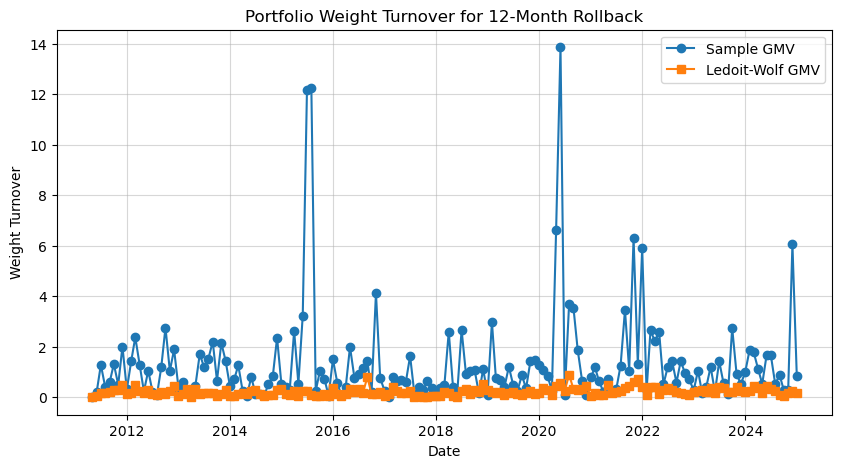

Average monthly turnover (GMV): 1.3143009097042588
Average monthly turnover (LW-GMV): 0.21808225697008082


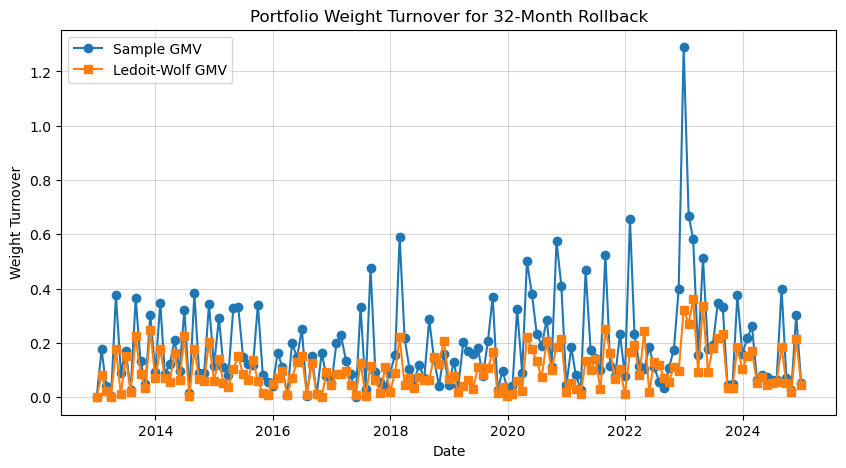

Average monthly turnover (GMV): 0.1864920415572606
Average monthly turnover (LW-GMV): 0.09861560424843609


In [37]:
# Plot turnover
plt.figure(figsize=(10,5))
plt.plot(turnover_12['gmv'], marker='o', label='Sample GMV')
plt.plot(turnover_12['lw_gmv'], marker='s', label='Ledoit-Wolf GMV')
plt.xlabel('Date')
plt.ylabel('Weight Turnover')
plt.title(f'Portfolio Weight Turnover for 12-Month Rollback')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Optional: print average turnover
print("Average monthly turnover (GMV):", turnover_12['gmv'].mean())
print("Average monthly turnover (LW-GMV):", turnover_12['lw_gmv'].mean())


# Plot turnover
plt.figure(figsize=(10,5))
plt.plot(turnover_32['gmv'], marker='o', label='Sample GMV')
plt.plot(turnover_32['lw_gmv'], marker='s', label='Ledoit-Wolf GMV')
plt.xlabel('Date')
plt.ylabel('Weight Turnover')
plt.title(f'Portfolio Weight Turnover for 32-Month Rollback')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Optional: print average turnover
print("Average monthly turnover (GMV):", turnover_32['gmv'].mean())
print("Average monthly turnover (LW-GMV):", turnover_32['lw_gmv'].mean())